<h1 style="font-family:Times New Roman; font-size: 300%"><center>Machine Learning For Physics;Project 3 </center></h1>
<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Pre-Training Scheme vs new Loss Function</h2>

<p style="font-family:Times New Roman; font-size:120%">
    We know that the pre-training scheme works really well, but another option is to include the scheme inside a new loss function as an additional term. This approach has been done before, and in a way is a more "intuitive approach", as it is directly telling the neural network to simultaneously follow hamiltonian equations and conserve the energy. But the problem is that the non-converging solutions diverge pretty much instantly, including a small additional term would likely not mitigate this. This is what this notebook will test.
</p>

In [1]:
using Pkg; Pkg.activate("~/.julia/environments/v1.11.1")
Pkg.add("Revise"); using Revise
using Lux, Optimisers, Plots, Statistics, Random, LinearAlgebra, Zygote,Distributions,NBInclude
Pkg.add("MLUtils"); using MLUtils

includet("Data.jl")
includet("NeuralNetwork.jl")
using Base.Threads

  Activating project at `~/~/.julia/environments/v1.11.1`
   Resolving package versions...
  No Changes to `~/~/.julia/environments/v1.11.1/Project.toml`
  No Changes to `~/~/.julia/environments/v1.11.1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/~/.julia/environments/v1.11.1/Project.toml`
  No Changes to `~/~/.julia/environments/v1.11.1/Manifest.toml`
┌ Warning: skipping callee Main.:(var"#RK4_step#6") (called by Main.RK4_step) due to AssertionError("isexpr(bodystmt, :call)")
└ @ LoweredCodeUtils ~/.julia/packages/LoweredCodeUtils/h7PQC/src/signatures.jl:328


In [2]:
rng = Random.MersenneTwister(42)

fieldd = meshgrid(20, train=false)
spring_field = grads_ideal_pend(fieldd).*0.1

t, x_train,y_train = generate_data(grads_ideal_pend, 25, 30, 4*pi, sigma=0.01, sampler=sample_pend,min_e=1.3, max_e=2.3) |>f32
_, x_test, y_test = generate_data(grads_ideal_pend, 1, 30, 4*pi, sigma=0.01, sampler=sample_pend,min_e=1.3, max_e=2.3) |>f32

x_Train = reshape(x_train, 2, 25*30) #.|>f32
y_Train = reshape(y_train, 2, 25*30) #.|>f32

train_data = DataLoader((x_Train,y_Train),batchsize=30)

25-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, batchsize=30)
  with first element:
  (2×30 Matrix{Float32}, 2×30 Matrix{Float32},)

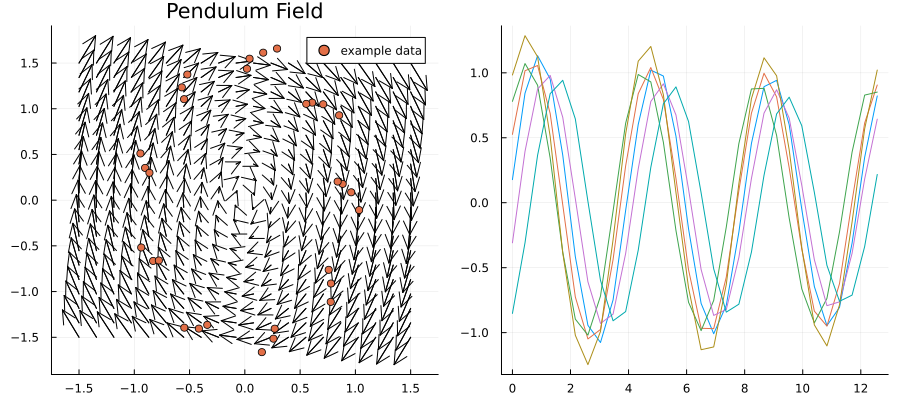

In [3]:
quiver(fieldd[1, :],fieldd[2, :],quiver=(spring_field[1, :], spring_field[2, :]), layout=(1,2),size=(900,400), title="Pendulum Field", label="train data",c=:black)
for i in 2:7
    plot!(t, x_train[1,:,i], subplot=2,legend=false)
end
scatter!(x_train[1,:,1], x_train[2,:,1], label="example data",subplot=1)

In [6]:
function Energy_Loss(model,input, ps, st)
    # Compute mean squared error between H_model and H_target
    smodel = StatefulLuxLayer{true}(model, ps, st)
    E_anal = pendulum(input[1,:], input[2,:]) #Analytical hamiltonian energy
    E_est = smodel(input) #Model estimation
    errs = abs.(E_anal.-E_est)
    return mean(errs)
end

function lossHNN_E(model, input, ps, st,target)
    smodel = StatefulLuxLayer{true}(model, ps, st)
    E_loss = Energy_Loss(model, input, ps, st) #New Additional Term
    H = only(Zygote.gradient(Base.Fix1(sum, abs2) ∘ smodel, input))
    n = size(H, 1) ÷ 2
    pred = vcat(selectdim(H, 1, (n + 1):(2n)), -selectdim(H, 1, 1:n)) # dH/dx, dH/dp --> dH/dp, -dH/dx
    
    #Technically, the new term is multiplied by a hyperparameter, 
    #but is just set to 0.1 here, which is reasonable
    
    return mean(abs2, pred .- target) + 0.1*E_loss 
end

lossHNN_E (generic function with 1 method)

In [7]:
activations = [tanh, sigmoid, mish, swish, gelu]
gains = [.1, .5, 1, 2^0.5, 5/3,2, 5]
activations_str = ["tanh", "sigmoid", "mish", "swish", "gelu"]

MSE_valsk = zeros(length(activations), length(gains))
MSE_valsg = zeros(length(activations), length(gains))
MSE_valso = zeros(length(activations), length(gains))

    
    
Threads.@threads for a_idx in 1:length(activations)
    act=activations[a_idx]
    Threads.@threads for g_idx in 1:length(gains)
        g_val=gains[g_idx]
        println("Doing $(activations_str[a_idx]) | Gain $(g_val)")
        _, LuxH_k = models(2, 64, act, Kaiming(g_val),1)
        _, LuxH_g = models(2, 64, act, Glorot(g_val),1)
        _, LuxH_o = models(2, 64, act, Orthogonal(g_val),1)

        
        #println(" -----  Training Kaiming  ----- ")
        pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN_E, train_data, x_test, y_test;epochs=1200,rng_nr=4001, pretrain=false)
        lossk = lossHNN(LuxH_k, x_test,pHNN_k, sHNN_k ,y_test)
        MSE_valsk[a_idx,g_idx] = lossk

        #println(" -----  Training Glorot  ----- ")
        pHNN_g, sHNN_g = train_model(LuxH_g, lossHNN_E, train_data, x_test, y_test;epochs=1200,rng_nr=4001,pretrain=false)
        lossg = lossHNN(LuxH_g, x_test,pHNN_g, sHNN_g ,y_test)
        MSE_valsg[a_idx,g_idx] = lossg

        #println(" -----  Training Orthogonal  ----- ")
        pHNN_o, sHNN_o = train_model(LuxH_o, lossHNN_E, train_data, x_test, y_test;epochs=1200,rng_nr=4001,pretrain=false)
        losso = lossHNN(LuxH_o, x_test, pHNN_o, sHNN_o ,y_test)
        MSE_valso[a_idx,g_idx] = losso

    end
end

Doing sigmoid | Gain 0.1
Doing sigmoid | Gain 1.6666666666666667
Doing sigmoid | Gain 1.4142135623730951
Doing mish | Gain 1.4142135623730951
Doing mish | Gain 0.5
Doing sigmoid | Gain 5.0
Doing tanh | Gain 1.4142135623730951
Doing tanh | Gain 1.6666666666666667
Doing swish | Gain 2.0
Doing swish | Gain 1.0
Doing tanh | Gain 0.5
Doing gelu | Gain 0.1
Epoch=200 :loss = 0.692698860168457
Epoch=200 :loss = 0.32758082896471025
Epoch=200 :loss = 0.5972097992897034
Doing tanh | Gain 1.0
Doing gelu | Gain 5.0
Doing mish | Gain 5.0
Epoch=200 :loss = 0.5799905002117157
Doing tanh | Gain 5.0
Epoch=200 :loss = 0.2946167692542076
Epoch=200 :loss = 0.6566216111183166
Epoch=200 :loss = 0.7787639498710632
Epoch=400 :loss = 0.6542182803153992
Epoch=200 :loss = 0.7651804685592651
Epoch=400 :loss = 0.5724208652973175
Epoch=200 :loss = 0.27740573361516
Epoch=200 :loss = 0.6641572654247284
Epoch=400 :loss = 0.5613239884376526
Epoch=400 :loss = 0.3000200465321541
Doing tanh | Gain 0.1
Epoch=400 :loss = 0.2

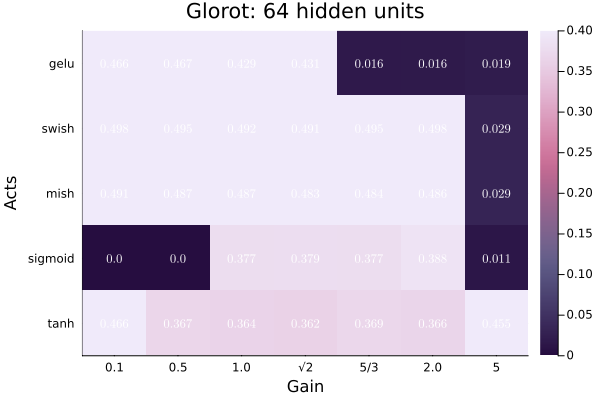

In [8]:
gain_str = ["0.1", "0.5", "1.0", "√2", "5/3", "2.0", "5"]
hg = heatmap(MSE_valsg, cmap=:acton,clim=(0, 0.4),title="Glorot: 64 hidden units", 
    yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
    ylabel="Acts",xlabel="Gain")
annotate!(hg,[(j, i, text(round(MSE_valsg[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
hg 

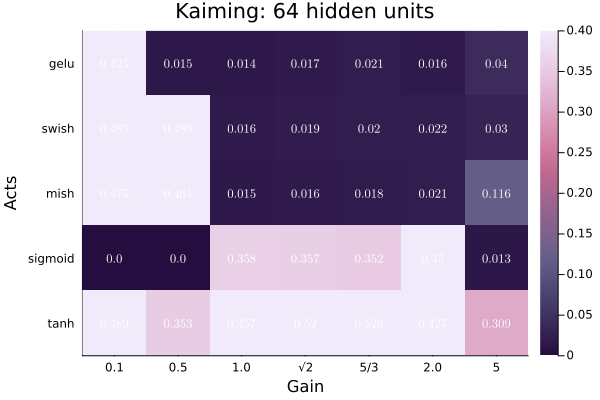

In [9]:
hk = heatmap(MSE_valsk, cmap=:acton, clim=(0,0.4),title="Kaiming: 64 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(hk,[(j, i, text(round(MSE_valsk[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
hk 

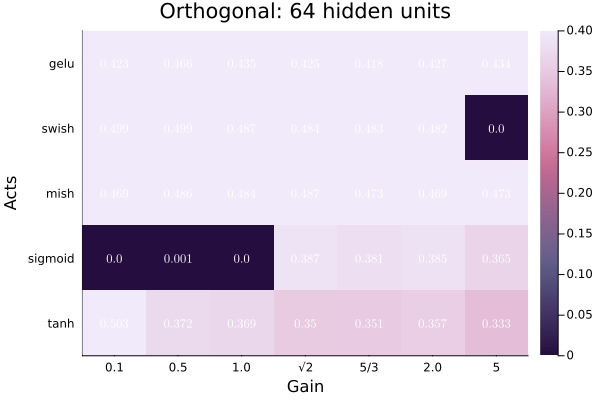

In [10]:
ho = heatmap(MSE_valso, cmap=:acton, clim=(0,0.4),title="Orthogonal: 64 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(ho,[(j, i, text(round(MSE_valso[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
ho 

In [11]:
activations = [tanh, sigmoid, mish, swish, gelu]
gains = [.1, .5, 1, 2^0.5, 5/3,2, 5]
activations_str = ["tanh", "sigmoid", "mish", "swish", "gelu"]

MSE_valsk2 = zeros(length(activations), length(gains))
MSE_valsg2 = zeros(length(activations), length(gains))
MSE_valso2 = zeros(length(activations), length(gains))

    
    
Threads.@threads for a_idx in 1:length(activations)#for (a_idx, act) in enumerate(activations)
    act=activations[a_idx]
    Threads.@threads for g_idx in 1:length(gains)
        g_val=gains[g_idx]
        println("Doing $(activations_str[a_idx]) | Gain $(g_val)")
        _, LuxH_k = models(2, 64, act, Kaiming(g_val),2)
        _, LuxH_g = models(2, 64, act, Glorot(g_val),2)
        _, LuxH_o = models(2, 64, act, Orthogonal(g_val),2)

        
        #println(" -----  Training Kaiming  ----- ")
        pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN_E, train_data, x_test, y_test;epochs=1200,rng_nr=4001, pretrain=false)
        lossk = lossHNN(LuxH_k, x_test,pHNN_k, sHNN_k ,y_test)
        MSE_valsk2[a_idx,g_idx] = lossk

        #println(" -----  Training Glorot  ----- ")
        pHNN_g, sHNN_g = train_model(LuxH_g, lossHNN_E, train_data, x_test, y_test;epochs=1200,rng_nr=4001,pretrain=false)
        lossg = lossHNN(LuxH_g, x_test,pHNN_g, sHNN_g ,y_test)
        MSE_valsg2[a_idx,g_idx] = lossg

        #println(" -----  Training Orthogonal  ----- ")
        pHNN_o, sHNN_o = train_model(LuxH_o, lossHNN_E, train_data, x_test, y_test;epochs=1200,rng_nr=4001,pretrain=false)
        losso = lossHNN(LuxH_o, x_test, pHNN_o, sHNN_o ,y_test)
        MSE_valso2[a_idx,g_idx] = losso

    end
end

Doing tanh | Gain 0.1
Doing tanh | Gain 2.0
Doing mish | Gain 2.0
Doing tanh | Gain 1.6666666666666667
Doing mish | Gain 0.1
Doing mish | Gain 5.0
Doing sigmoid | Gain 0.1
Doing tanh | Gain 5.0
Doing gelu | Gain 5.0
Doing gelu | Gain 2.0
Doing gelu | Gain 1.0
Doing swish | Gain 2.0
Epoch=200 :loss = 1.3762176513671875
Epoch=200 :loss = 0.4646629750728607
Epoch=200 :loss = 83.99253998994827
Doing sigmoid | Gain 1.0
Doing sigmoid | Gain 2.0
Epoch=200 :loss = 0.4736063122749329
Epoch=200 :loss = 0.709917414188385
Epoch=200 :loss = 0.47810555100440977
Epoch=200 :loss = 0.05081571778282523
Epoch=400 :loss = 0.47300027608871464
Doing gelu | Gain 0.1
Epoch=200 :loss = 0.5805589079856872
Epoch=200 :loss = 53.016827166080475
Epoch=200 :loss = 0.6808288335800171
Doing mish | Gain 1.6666666666666667
Epoch=200 :loss = 0.26644023358821867
Epoch=400 :loss = 0.4553837954998017
Epoch=400 :loss = 0.5129487335681915
Epoch=400 :loss = 6.740704548358917
Epoch=400 :loss = 0.05025538635673002
Epoch=400 :los

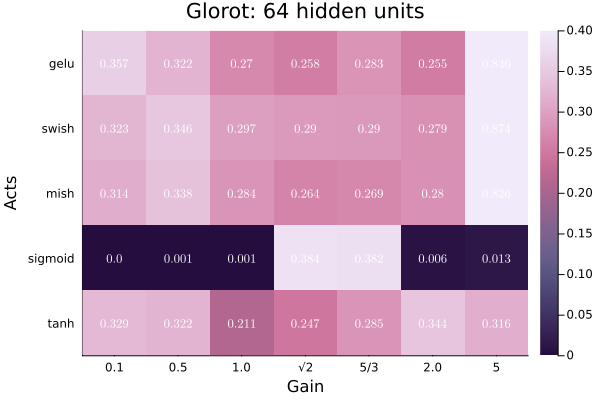

In [12]:
gain_str = ["0.1", "0.5", "1.0", "√2", "5/3", "2.0", "5"]
hg2 = heatmap(MSE_valsg2, cmap=:acton,clim=(0, 0.4),title="Glorot: 64 hidden units", 
    yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
    ylabel="Acts",xlabel="Gain")
annotate!(hg2,[(j, i, text(round(MSE_valsg2[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
hg2

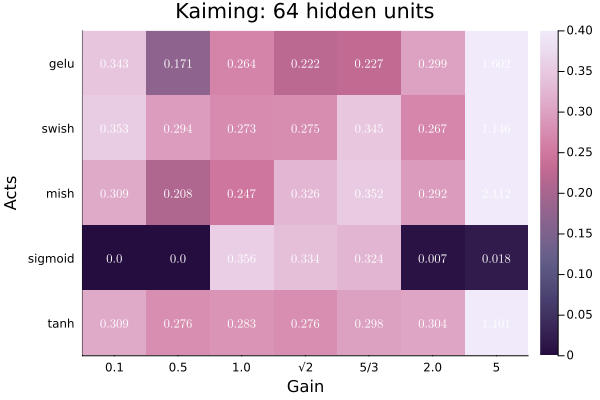

In [13]:
hk2 = heatmap(MSE_valsk2, cmap=:acton, clim=(0,0.4),title="Kaiming: 64 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(hk2,[(j, i, text(round(MSE_valsk2[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
hk2 

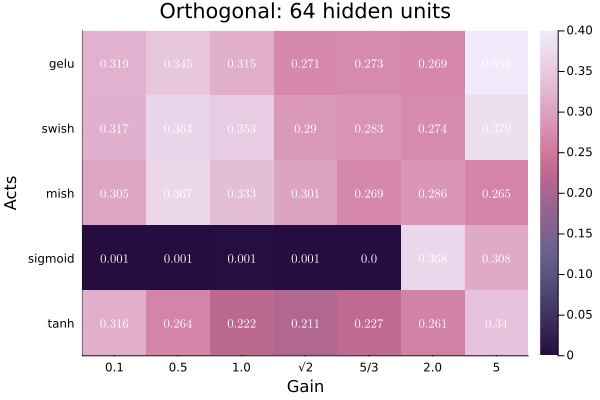

In [15]:
ho2 = heatmap(MSE_valso2, cmap=:acton, clim=(0,0.4),title="Orthogonal: 64 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(ho2,[(j, i, text(round(MSE_valso2[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
ho2

In [17]:
p = range(-3,3,100)
q = range(-pi,pi,100)
p_m = repeat(p, inner=100)
q_m = repeat(q, outer=100)
matrix = hcat(q_m, p_m)' #Defining the data to find the heatmaps

2×10000 adjoint(::Matrix{Float64}) with eltype Float64:
 -3.14159  -3.07813  -3.01466  …  2.95119  3.01466  3.07813  3.14159
 -3.0      -3.0      -3.0         3.0      3.0      3.0      3.0

Epoch=200 :loss = 0.04956632503308356
Epoch=400 :loss = 0.049334779463242745
Epoch=600 :loss = 0.04930879588355311
Epoch=800 :loss = 0.049286912550451235
Epoch=1000 :loss = 0.049286674312315884


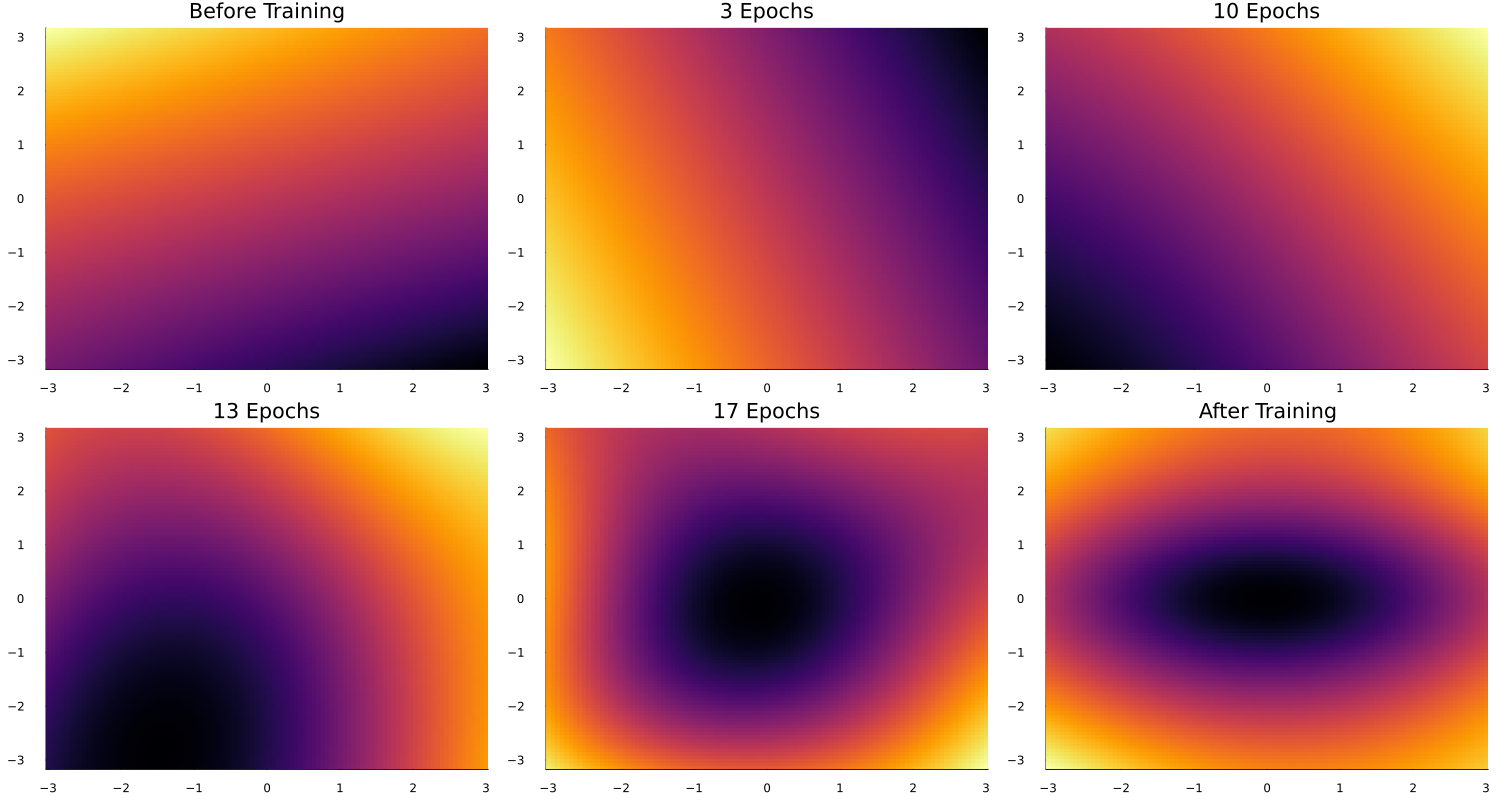

In [34]:
_, LuxH_k = models(2, 64, sigmoid, Glorot(0.5),1) #Fetch models, now a Converging model

# We display the model while it is not trained
pHNN_k, sHNN_k = Lux.setup(Random.MersenneTwister(4001), LuxH_k) 
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap(subplot=1,layout=(2,3),p,q, reshape(est, 100, 100),size=(1500,800),title="Before Training",cbar=false)

# We display the model when it has trained only for 3 epochs
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN_E, train_data, x_test, y_test;epochs=3,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap!(p, q, subplot=2, reshape(est, 100, 100),title="3 Epochs",cbar=false)


# We display the model when it has trained only for 10 epochs
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN_E, train_data, x_test, y_test;epochs=10,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap!(p, q, subplot=3, reshape(est, 100, 100),title="10 Epochs",cbar=false)


# We display the model when it has trained only for 13 epochs
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN_E, train_data, x_test, y_test;epochs=13,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap!(p, q, subplot=4, reshape(est, 100, 100),title="13 Epochs",cbar=false)


# We display the model when it has trained only for 17 epochs
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN_E, train_data, x_test, y_test;epochs=17,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap!(p, q, subplot=5, reshape(est, 100, 100),title="17 Epochs",cbar=false)


# We display the model when it is trained and compare
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN_E, train_data, x_test, y_test;epochs=1000,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap!(p, q, subplot=6, reshape(est, 100, 100),title="After Training",cbar=false)

Epoch=200 :loss = 0.6413741409778595
Epoch=400 :loss = 0.6379576921463013
Epoch=600 :loss = 0.6298460364341736
Epoch=800 :loss = 0.6082498550415039
Epoch=1000 :loss = 0.5760361135005951
Epoch=1200 :loss = 0.5566294014453887
Epoch=1400 :loss = 0.5536100268363953
Epoch=1600 :loss = 0.5518613338470459
Epoch=1800 :loss = 0.5458341836929321
Epoch=2000 :loss = 0.5384915888309478
Epoch=2200 :loss = 0.5321701884269714
Epoch=2400 :loss = 0.5274503290653229
Epoch=2600 :loss = 0.5241357803344726
Epoch=2800 :loss = 0.5218373119831086
Epoch=3000 :loss = 0.5201443731784821
Epoch=3200 :loss = 0.518644917011261
Epoch=3400 :loss = 0.5170297980308532
Epoch=3600 :loss = 0.5151826798915863
Epoch=3800 :loss = 0.5132091403007507
Epoch=4000 :loss = 0.5112893998622894
Epoch=4200 :loss = 0.5095119655132294
Epoch=4400 :loss = 0.5078755915164948
Epoch=4600 :loss = 0.506353235244751
Epoch=4800 :loss = 0.5049063980579376
Epoch=5000 :loss = 0.50355623960495
Epoch=5200 :loss = 0.5023485362529755
Epoch=5400 :loss = 0

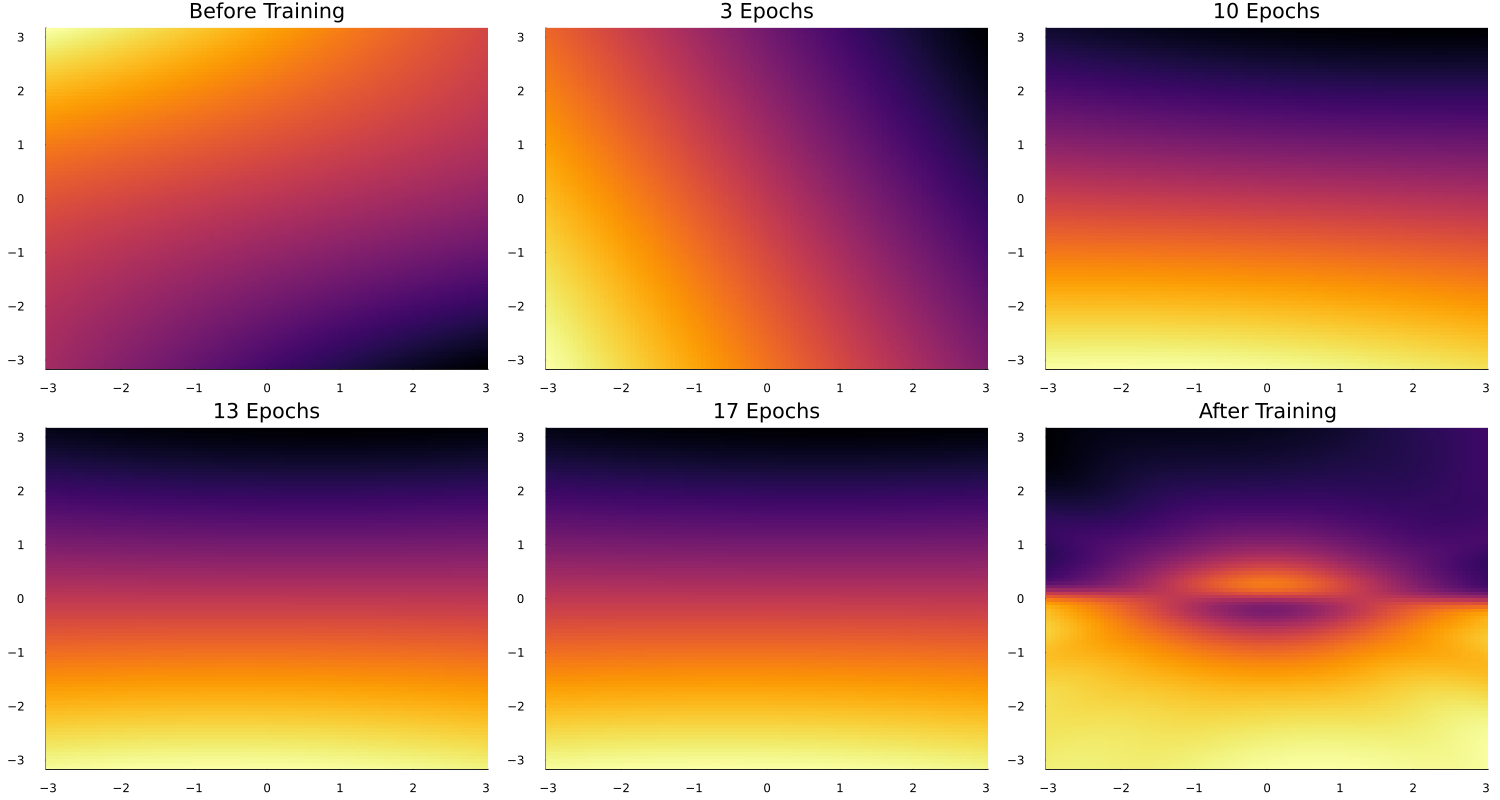

In [35]:
_, LuxH_k = models(2, 64, sigmoid, Glorot(1),1) #Fetch models, now a Converging model

# We display the model while it is not trained
pHNN_k, sHNN_k = Lux.setup(Random.MersenneTwister(4001), LuxH_k) 
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap(subplot=1,layout=(2,3),p,q, reshape(est, 100, 100),size=(1500,800),title="Before Training",cbar=false)

# We display the model when it has trained only for 3 epochs
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN_E, train_data, x_test, y_test;epochs=3,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap!(p, q, subplot=2, reshape(est, 100, 100),title="3 Epochs",cbar=false)


# We display the model when it has trained only for 10 epochs
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN_E, train_data, x_test, y_test;epochs=10,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap!(p, q, subplot=3, reshape(est, 100, 100),title="10 Epochs",cbar=false)


# We display the model when it has trained only for 13 epochs
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN_E, train_data, x_test, y_test;epochs=13,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap!(p, q, subplot=4, reshape(est, 100, 100),title="13 Epochs",cbar=false)


# We display the model when it has trained only for 17 epochs
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN_E, train_data, x_test, y_test;epochs=17,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap!(p, q, subplot=5, reshape(est, 100, 100),title="17 Epochs",cbar=false)


# We display the model when it is trained and compare
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN_E, train_data, x_test, y_test;epochs=10000,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap!(p, q, subplot=6, reshape(est, 100, 100),title="After Training",cbar=false)

<p style="font-family:Times New Roman; font-size:120%">
    These two examples are initially almost identical, but lead to very different results. This shows that although the new term in the loss-function can improve performance, it does not fully handle the problem. There are cases where it does not lead strongly enough into the convergent solution. When the non-convergent solution has a strong local minimum, the additional term is not powerfull enough to lead it away, which is the end-goal. Therefor, it might be better to pre-train, so that the models are initially already led towards the convergent solutions.
</p>
